In [1]:
import json
import os

from analysis import *
from plot_main import *

plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams.update({'font.size': 20})
plt.rcParams['image.interpolation']='nearest'


/Users/f005d7d/opt/miniconda3/envs/layla/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/f005d7d/opt/miniconda3/envs/layla/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


### Load model and run simulation on experimental reward schedule and stimuli

In [2]:
# exp_dir = '/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/Attn-WM-RNN/exp/dual_hierarchical_good_based/'
# os.chdir('/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/Attn-WM-RNN')
os.chdir('/Volumes/f005d7d/attn-rnn/Attn-WM-RNN')
exp_dir = 'exp/dual_hierarchical_good_based'

f = open(os.path.join(exp_dir, 'args.json'), 'r')
args = json.load(f)
print('loaded args')
# load model
ITI = 0.25
choice_start = 0.4
rwd_start = 0.6
stim_end = 0.75

exp_times = {
    'start_time': -ITI,
    'end_time': stim_end,
    'stim_onset': 0.0,
    'stim_end': stim_end,
    'rwd_onset': rwd_start,
    'rwd_end': stim_end,
    'choice_onset': choice_start,
    'choice_end': rwd_start,
    'total_time': ITI+stim_end,
    'dt': args['dt']}
log_interval = 1
task_mdprl = MDPRL(exp_times, args['input_type'])
print('loaded task')

loaded args
loaded task


In [3]:
input_size = {
    'feat': args['stim_dim']*args['stim_val'],
    'feat+obj': args['stim_dim']*args['stim_val']+args['stim_val']**args['stim_dim'], 
    'feat+conj+obj': args['stim_dim']*args['stim_val']+args['stim_dim']*args['stim_val']*args['stim_val']+args['stim_val']**args['stim_dim'],
}[args['input_type']]

args['num_options'] = 2 if 'double' in args['task_type'] else 1

num_options = 1 if args['task_type']=='value' else 2
if args['decision_space']=='action':
    output_size = num_options
elif args['decision_space']=='good':
    output_size = args['stim_val']**args['stim_dim']
else:
    raise ValueError('Invalid decision space')
args['output_size'] = output_size


model_specs = {'input_size': input_size, 'hidden_size': args['hidden_size'], 'output_size': output_size, 'num_options': num_options,
                'plastic': args['plas_type']=='all', 'activation': args['activ_func'],
                'dt': args['dt'], 'tau_x': args['tau_x'], 'tau_w': args['tau_w'], 
                'e_prop': args['e_prop'], 'init_spectral': args['init_spectral'], 'balance_ei': args['balance_ei'],
                'sigma_rec': args['sigma_rec'], 'sigma_in': args['sigma_in'], 'sigma_w': args['sigma_w'], 
                'rwd_input': args.get('rwd_input', False), 'action_input': args['action_input'], 
                'sep_lr': args['sep_lr'], 'num_choices': 2 if 'double' in args['task_type'] else 1,
                'structured_conn': args['structured_conn'], 'spatial_attn_agg': args['spatial_attn_agg'], 'num_areas': args['num_areas'],
                'inter_regional_sparsity': (1, 1), 'inter_regional_gain': (1, 1), 'input_plastic': not args['input_plas_off']}

E_SIZE = int(args['hidden_size']*args['e_prop'])
I_SIZE = int(args['hidden_size']*(1-args['e_prop']))
NUM_AREAS = args['num_areas']

model = HierarchicalRNN(**model_specs)
print(model)
for n, p in model.named_parameters():
    print(n, p.numel())

state_dict = torch.load(os.path.join(exp_dir, 'checkpoint.pth.tar'), map_location=torch.device('cpu'))['model_state_dict']
print(model.load_state_dict(state_dict))

: 

: 

In [4]:
# run model

import pickle

test_activities_dir = '/dartfs-hpc/scratch/f005d7d/attn-rnn/test_activities'

if os.path.exists(test_activities_dir):
    print('found previous record pickle, loading previous results')
    with open(test_activities_dir, 'rb') as f:
        losses, losses_means, losses_stds, all_saved_states, all_indices, all_probs = pickle.load(f)
    print('loaded previous results')
else:
    losses, losses_means, losses_stds, all_saved_states, all_indices, all_probs = run_model(args, model, task_mdprl)
    print('simulation complete')
    with open(test_activities_dir, 'wb') as f:
        pickle.dump([losses, losses_means, losses_stds, all_saved_states, all_indices, all_probs], f)
    print(f'saved results to {test_activities_dir}')

# stim_probs_ordered = all_probs.reshape(27, 10)[all_indices[:,i,0]]

# selectivity, sort_inds, cluster_label = unit_selectivity(all_saved_states['hs'], np.argmax(stim_probs_ordered, axis=-1), 
#                                                     e_size=int(args['e_prop']*args['hidden_size']))

found previous record pickle, loading previous results
loaded previous results


In [22]:
def run_model_all_pairs_with_hidden_init(args, model, task_mdprl, n_samples=10, hidden_init=None):
    model.eval()
    accs = []
    rwds = []
    all_indices = []
    all_probs = []
    all_saved_states_pre = defaultdict(list) # each entry has value of size (num pairs X num_samples X ...)
    all_saved_states_post = defaultdict(list)
    all_saved_states = defaultdict(list)
    output_size = args['output_size']
    with torch.no_grad():
        for pair_idx in tqdm.tqdm(range(task_mdprl.pairs.shape[0])):
            for batch_idx in range(n_samples):
                DA_s, ch_s, pop_s, index_s, prob_s, output_mask = \
                    task_mdprl.generateinput(batch_size=1, N_s=0, num_choices=args['num_options'], prob_index=task_mdprl.prob_mdprl, \
                                             stim_order=task_mdprl.pairs[pair_idx:pair_idx+1,:])
                acc = []
                curr_rwd = []
                hidden = hidden_init
                all_saved_states_pre
                    # first phase, give stimuli and no feedback
                output, hs, hidden, ss = model(pop_s['pre_choice'][0], hidden=hidden, 
                                                Rs=0*DA_s['pre_choice'], Vs=None,
                                                acts=torch.zeros(1, output_size)*DA_s['pre_choice'],
                                                save_weights=False, reinit_hidden=False)

                # add empty list for the current episode
                if batch_idx==0:
                    for k in ss.keys():
                        all_saved_states_pre[k].append([])
                        all_saved_states_post[k].append([])
#                     all_saved_states['whs_final'].append([])
                    all_saved_states_pre['hs'].append([])
                    all_saved_states_post['hs'].append([])

                # save pre-feedback states
                for k, v in ss.items():
                    all_saved_states_pre[k][-1].append(v)
                all_saved_states_pre['hs'][-1].append(hs) # [num_pairs, [num_samples_per_pair, [time_pre, 1, hidden_size]]]

                # use output to calculate action, reward, and record loss function
                action_valid = torch.argmax(output[-1,:,index_s[0]], -1) # the object that can be chosen (0~1), (batch size, )
                action = index_s[0, action_valid] # (batch size, )
                rwd = (torch.rand(args['batch_size'])<prob_s[0][range(args['batch_size']), action_valid]).float()
                acc.append((action_valid==torch.argmax(prob_s[0], -1)).float())    
                curr_rwd.append(rwd)
                
                # use the action (optional) and reward as feedback
                pop_post = pop_s['post_choice'][0]
                action_enc = torch.eye(output_size)[action]
                action_valid_enc = torch.eye(args['num_options'])[action_valid]
                pop_post = pop_post*action_valid_enc.reshape(1,1,args['num_options'],1)
                action_enc = action_enc*DA_s['post_choice']
                R = (2*rwd-1)*DA_s['post_choice']
                _, hs, hidden, ss = model(pop_post, hidden=hidden, Rs=R, Vs=None, acts=action_enc, save_weights=False)
                
                # save the post-feedback states
                for k, v in ss.items():
                    all_saved_states_post[k][-1].append(v)
                all_saved_states_post['hs'][-1].append(hs) # [num_pairs, [num_samples_per_pair, [time_post, 1, hidden_size]]]

#             print(len(all_saved_states_pre['hs'][0][0]))


            # stack trials for each session
            for k in all_saved_states_pre.keys():
                all_saved_states_pre[k][-1] = torch.stack(all_saved_states_pre[k][-1], axis=0)
            for k in all_saved_states_post.keys():
                all_saved_states_post[k][-1] = torch.stack(all_saved_states_post[k][-1], axis=0)
            for k in all_saved_states.keys():
                all_saved_states[k][-1] = torch.stack(all_saved_states[k][-1], axis=0)
            # [num_pairs, [num_samples_per_pair, time_steps, 1, hidden_size]]
            

            # save accuracies and reward
            acc = torch.stack(acc, dim=0)
            curr_rwd = torch.stack(curr_rwd, dim=0)
            accs.append(acc)
            rwds.append(curr_rwd)
            all_indices.append(index_s)
            all_probs.append(prob_s)

        # concatenate all accuracies and rewards
        accs = torch.cat(accs, dim=1)
        rwds = torch.cat(rwds, dim=1)
        accs_means = accs.mean(1) # loss per trial
        accs_stds = accs.std(1)/math.sqrt(n_samples) # loss per trial
        rwds_means = rwds.mean(1) # loss per trial
        rwds_stds = rwds.std(1)/math.sqrt(n_samples) # loss per trial

        # concatenate all saved states
        for k in all_saved_states_pre.keys():
            all_saved_states_pre[k] = torch.stack(all_saved_states_pre[k], axis=0)
        for k in all_saved_states_post.keys():
            all_saved_states_post[k] = torch.stack(all_saved_states_post[k], axis=0)
        for k in all_saved_states.keys():
            all_saved_states[k] = torch.stack(all_saved_states[k], axis=0)
        # [num_pairs, num_samples_per_pair, time_steps, 1, hidden_size]

        # merge pre and post if necessary
        for k in all_saved_states_pre.keys():
            all_saved_states[k] = torch.cat([all_saved_states_pre[k], all_saved_states_post[k]], dim=2)

        for k, v in all_saved_states.items():
            print(k, v.shape)
        
        all_indices = torch.stack(all_indices, dim=1) # trials X batch size X 2
        all_probs = torch.stack(all_probs, dim=1)
        return [accs, rwds], [accs_means, rwds_means], [accs_stds, rwds_stds], all_saved_states

In [23]:
_, _, _, all_initial_saved_states = run_model_all_pairs_with_hidden_init(args, model, task_mdprl)


100%|██████████| 216/216 [00:44<00:00,  4.88it/s]

hs torch.Size([216, 10, 51, 1, 240])


### Learning Curve

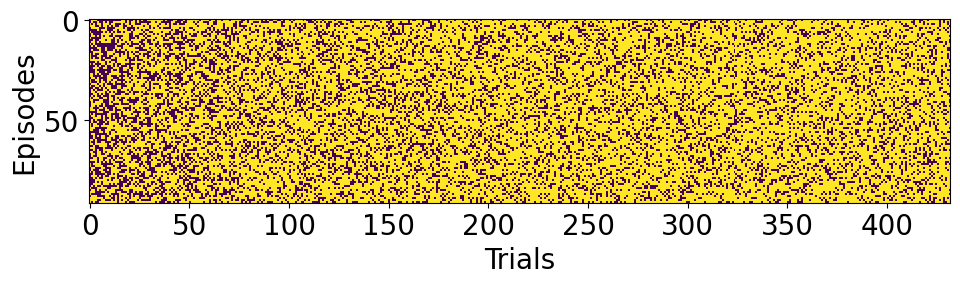

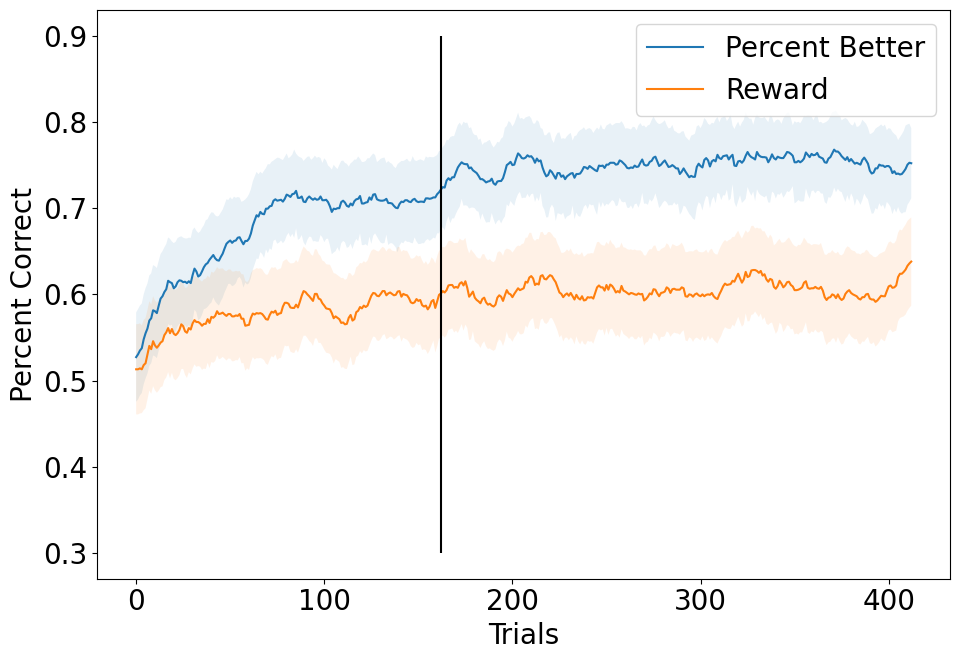

In [5]:
plot_learning_curve(args, losses, losses_means, losses_stds)

In [9]:
def plot_weight_summary(args, ws):
    trials, timesteps, batch_size, post_dim, pre_dim = ws.shape
    assert(timesteps==1)
    ws = ws.squeeze()
    
    # norm of update
    fig = plt.figure()
    ax = fig.add_subplot()
    diff_ws = ((ws[1:]-ws[:-1])**2).sum([-1, -2])
    plot_mean_and_std(ax, diff_ws.mean(1), diff_ws.std(1)/np.sqrt(batch_size), None)
    ax.set_xlabel('Trial')
    ax.set_ylabel(r'$|\Delta W|_2$')
    fig.show()
    print('Finished calculating norm of update')

    # norm of weights
    fig = plt.figure()
    ax = fig.add_subplot()
    norm_ws = (ws**2).sum([-1, -2]) # frobenius norm
    plot_mean_and_std(ax, norm_ws.mean(1), norm_ws.std(1)/np.sqrt(batch_size), None)
    ax.set_xlabel('Trial')
    ax.set_ylabel(r'$|W|_2$')
    fig.show()
    print('Finished calculating weight norms')
    

    # variance of entries across trials
    fig = plt.figure()
    ax = fig.add_subplot()
    mean_ws = ws.mean(1, keepdims=True)
    std_ws = ((ws-mean_ws)**2).sum([-1, -2])
    plot_mean_and_std(ax, std_ws.mean(1), std_ws.std(1)/np.sqrt(batch_size), None)
    ax.set_xlabel('Trial')
    ax.set_ylabel('Cross session consistency')
    fig.show()
    print('Finished calculating consistency')

Finished calculating norm of update
Finished calculating weight norms
Finished calculating consistency


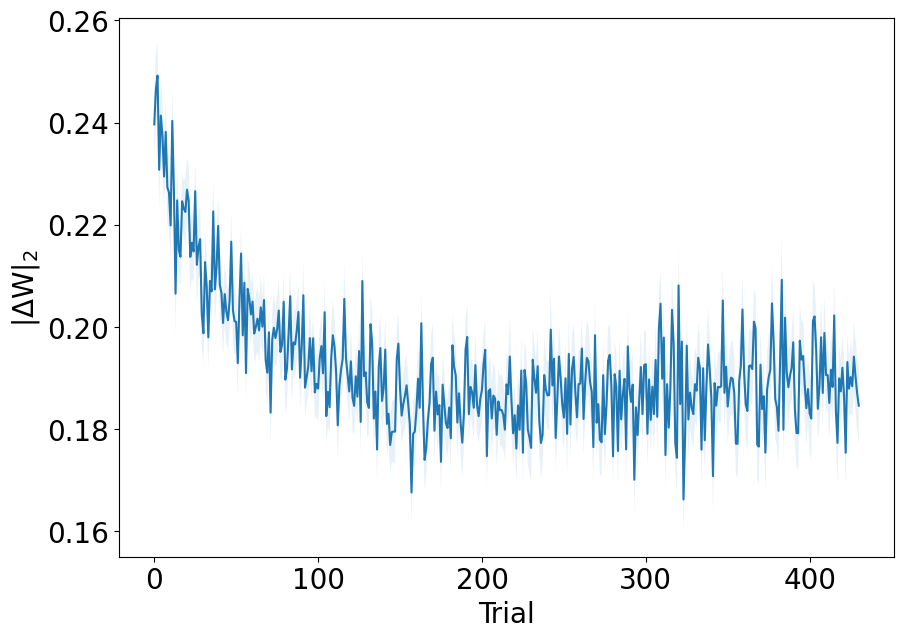

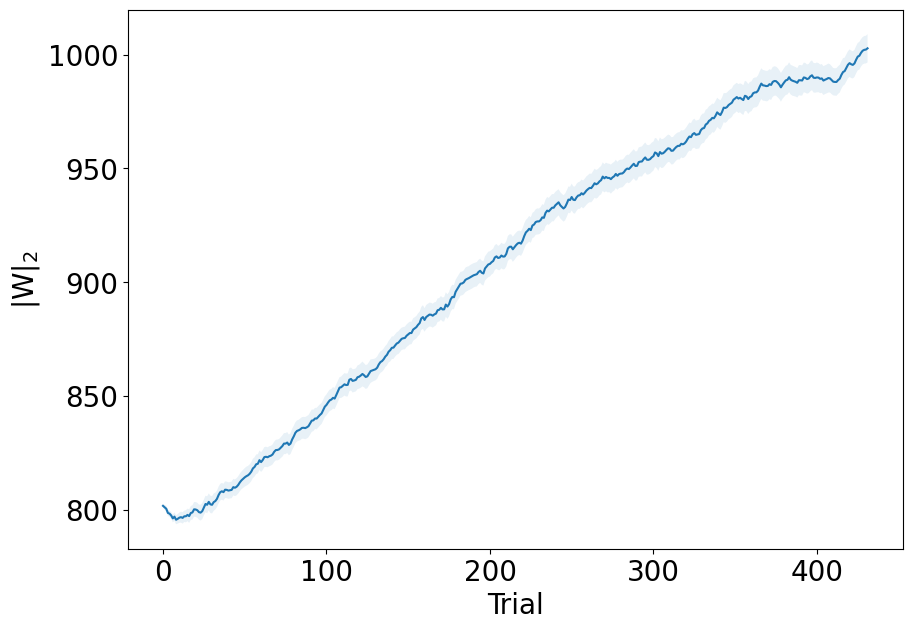

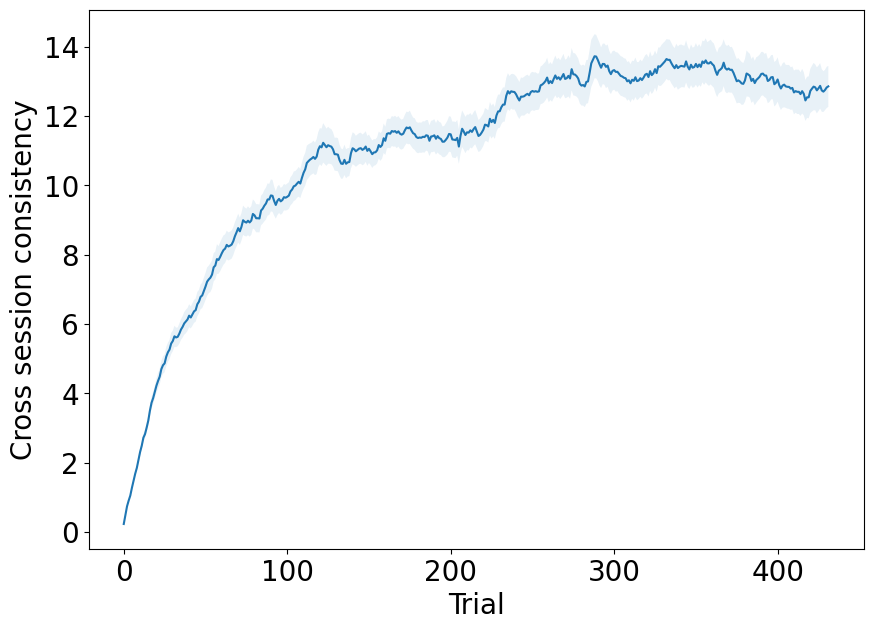

In [10]:
# all_saved_states['whs_final'].shape
plot_weight_summary(args, all_saved_states['whs_final'])

Regression eq: $h_t = \sum_{i=1}^3 \beta^F_{it}F_{it} + \sum_{i=1}^3 \beta^C_{it} C_{it} +\beta^O_{it}O_{it} + \epsilon_t$

In [16]:
all_lrs, all_cpds, all_betas = plot_tdr(all_saved_states['hs'], all_indices, task_mdprl.stim_encoding('all_onehot'), all_probs)

Calculating regression


100%|██████████| 432/432 [00:17<00:00, 25.38it/s]


Calculating CPDs


100%|██████████| 432/432 [00:42<00:00, 10.16it/s]


# Plot Initial Connectivity

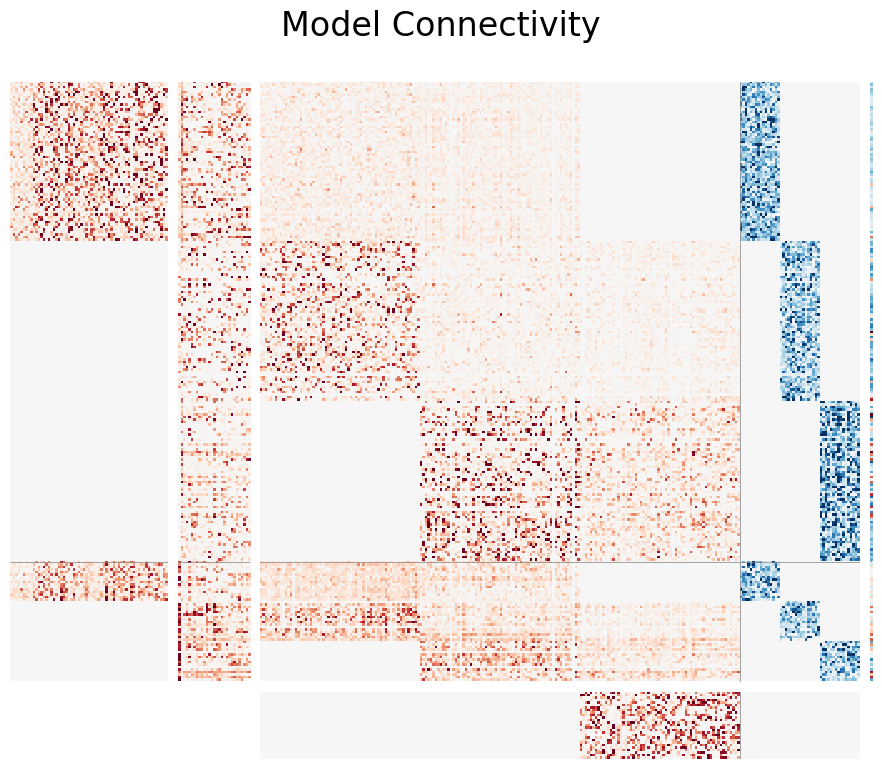

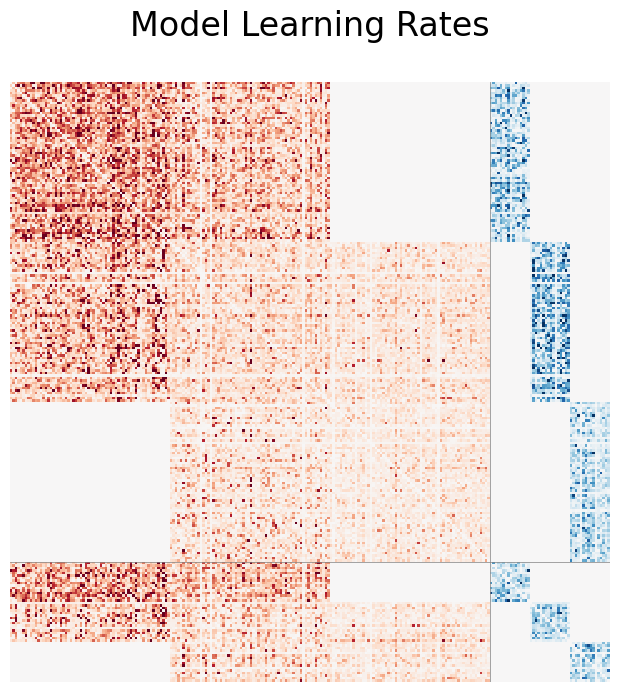

In [4]:
from matplotlib.pyplot import figure

plot_connectivity_lr(torch.arange(240), 
                             x2hw=model.rnn.x2h.effective_weight().detach(),
                             h2hw=model.rnn.h2h.effective_weight().detach(),
                             hb=state_dict['rnn.h2h.bias'].detach(),
                             h2ow=torch.cat([torch.zeros(27, 128), model.h2o.effective_weight().detach(), torch.zeros(27, 16*3)], dim=1),
                             aux2h=model.rnn.aux2h.effective_weight().detach(),
                             kappa_rec=model.rnn.kappa_rec.squeeze().abs().detach()*model.rnn.h2h.mask,
                             e_size=int(args['e_prop']*args['hidden_size'])*args['num_areas'], args=args)

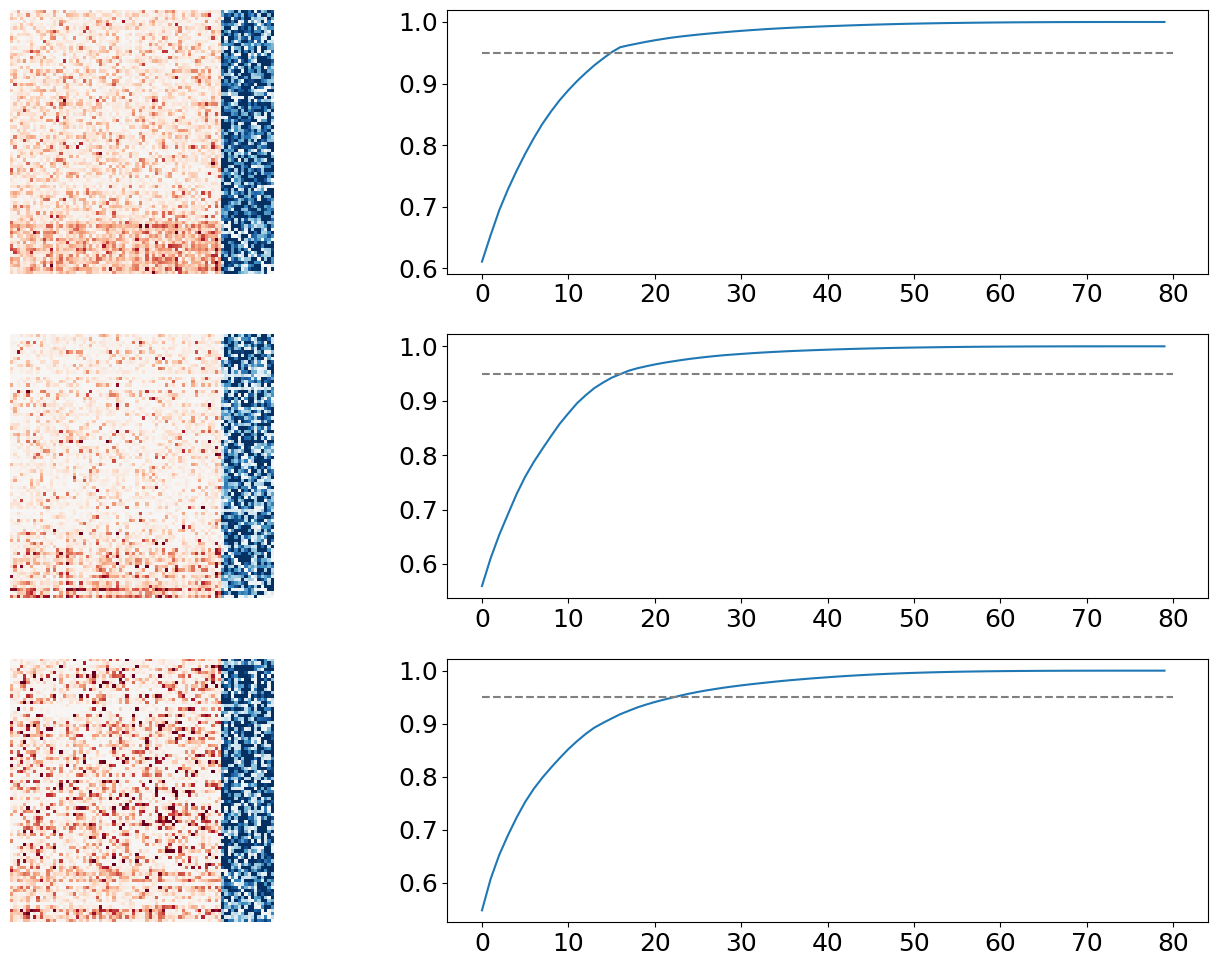

In [11]:
E_SIZE = 64
I_SIZE = 16

h2h = model.rnn.h2h.effective_weight().detach()

rec_intra = []
us = []
vhs = []
ss = []
for i in range(NUM_AREAS):
    rec_intra.append(h2h[list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                         list(range(3*E_SIZE+i*I_SIZE, 3*E_SIZE+(i+1)*I_SIZE))]
                      [:,list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                         list(range(3*E_SIZE+i*I_SIZE, 3*E_SIZE+(i+1)*I_SIZE))])
    u, s, vh = np.linalg.svd(rec_intra[i], full_matrices=False)
    us.append(u)
    vhs.append(vh)
    ss.append(s)
    
wlim = 0.25
fig, axes = plt.subplots(3, 2)
for i in range(NUM_AREAS):
    axes[i,0].imshow(rec_intra[i], vmax=wlim, vmin=-wlim, cmap='RdBu_r', interpolation='nearest')
    axes[i,1].plot(np.cumsum(ss[i]**2)/np.sum(ss[i]**2))
    axes[i,0].set_xticks([])
    axes[i,0].set_yticks([])
    axes[i,0].axis('off')
    axes[i,1].hlines(0.95, 0, 80, colors='grey', linestyles='dashed')
plt.tight_layout()
plt.show()

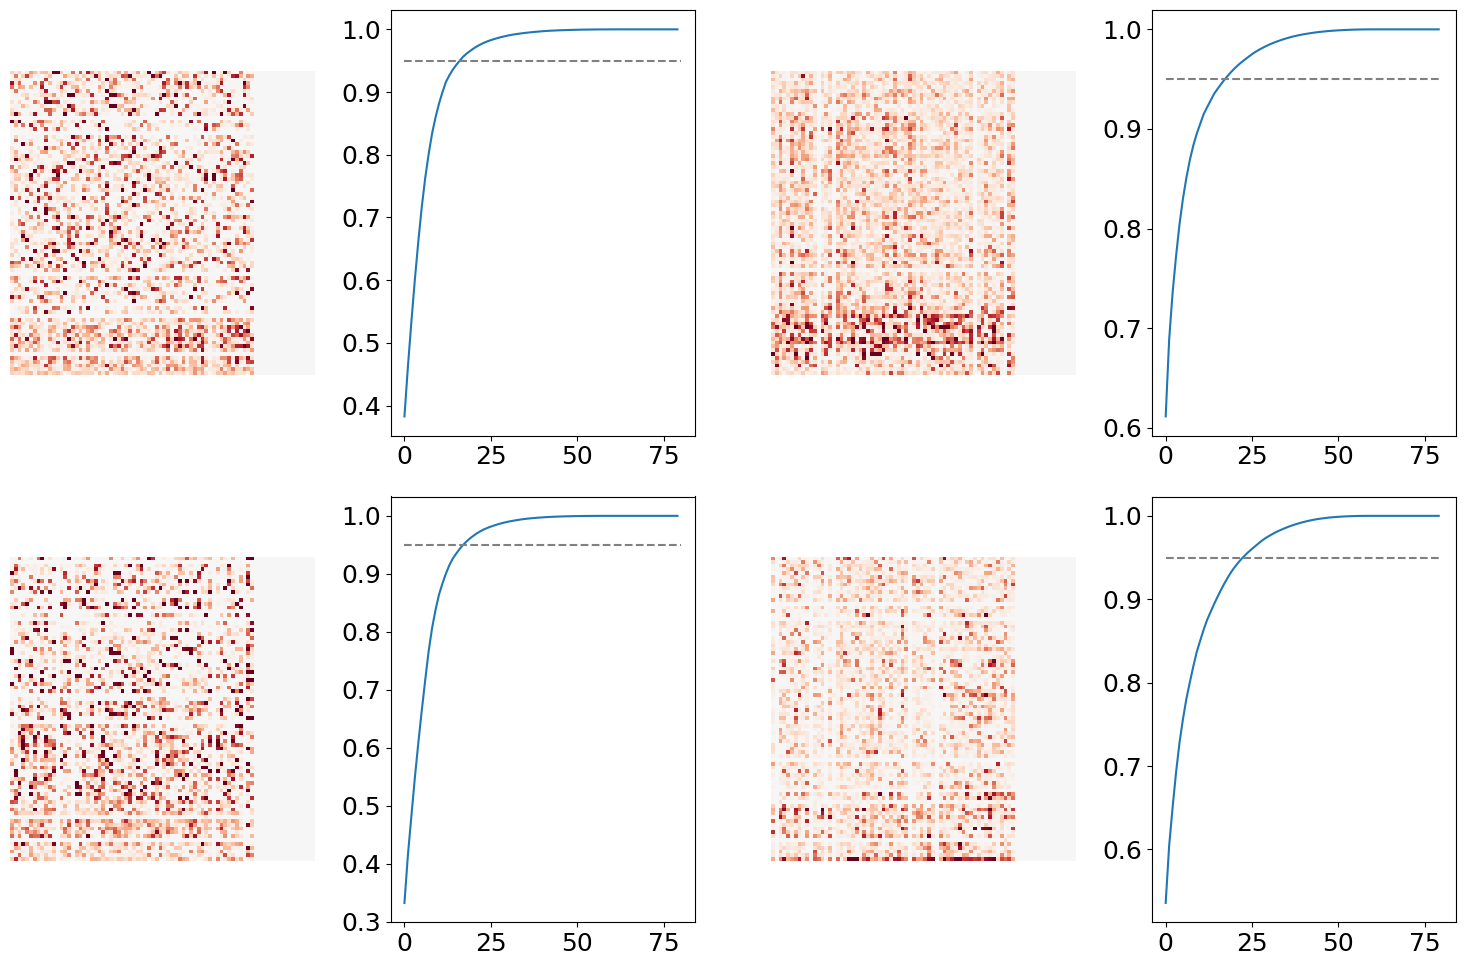

In [12]:
rec_inter_ff = []
rec_inter_fb = []
us_ff = []
us_fb = []
vhs_ff = []
vhs_fb = []
ss_ff = []
ss_fb = []
for i in range(NUM_AREAS-1):
   rec_inter_ff.append(h2h[list(range((i+1)*E_SIZE, (i+2)*E_SIZE))+\
                            list(range(3*E_SIZE+(i+1)*I_SIZE, 3*E_SIZE+(i+2)*I_SIZE))]
                         [:,list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                            list(range(3*E_SIZE+i*I_SIZE, 3*E_SIZE+(i+1)*I_SIZE))])
   rec_inter_fb.append(h2h[list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                            list(range(3*E_SIZE+i*I_SIZE, 3*E_SIZE+(i+1)*I_SIZE))]
                         [:,list(range((i+1)*E_SIZE, (i+2)*E_SIZE))+\
                            list(range(3*E_SIZE+(i+1)*I_SIZE, 3*E_SIZE+(i+2)*I_SIZE))])
   u, s, vh = np.linalg.svd(rec_inter_ff[i], full_matrices=False)
   us_ff.append(u)
   vhs_ff.append(vh)
   ss_ff.append(s)
   u, s, vh = np.linalg.svd(rec_inter_fb[i], full_matrices=False)
   us_fb.append(u)
   vhs_fb.append(vh)
   ss_fb.append(s)
   
    
fig, axes = plt.subplots(2,4)
wlim = 0.5
for i in range(NUM_AREAS-1):
    axes[i,0].imshow(rec_inter_ff[i], vmin=-wlim, vmax=wlim, cmap='RdBu_r')
    axes[i,0].set_xticks([])
    axes[i,0].set_yticks([])
    axes[i,0].axis('off')
    axes[i,1].plot(np.cumsum(ss_ff[i]**2)/np.sum(ss_ff[i]**2))
    axes[i,1].hlines(0.95, 0, 80, colors='grey', linestyles='dashed')
    axes[i,2].imshow(rec_inter_fb[i], vmin=-wlim/3, vmax=wlim/3, cmap='RdBu_r')
    axes[i,2].set_xticks([])
    axes[i,2].set_yticks([])
    axes[i,2].axis('off')
    axes[i,3].plot(np.cumsum(ss_fb[i]**2)/np.sum(ss_fb[i]**2))
    axes[i,3].hlines(0.95, 0, 80, colors='grey', linestyles='dashed')
plt.tight_layout()
plt.show()

# Subspace Analysis


### Decompose each input pattern as a sum of feature, conjunction, and object patterns
$I_{in,i} = I_{ft}(i)+I_{conj}(i)+I_{obj}(i)$

In [6]:
input_weight_inds = list(range(E_SIZE)) + list(range(E_SIZE*args['num_areas'], E_SIZE*args['num_areas']+I_SIZE))

stims, global_avg_in, ft_avg_in, conj_avg_in, obj_avg_in = get_input_encodings(
    model.rnn.x2h.effective_weight()[input_weight_inds].detach().numpy(), 
    task_mdprl.stim_encoding('all_onehot'))

# global_avg_out, ft_avg_out, conj_avg_out, obj_avg_out = get_input_encodings(
#     model.h2o.effective_weight().detach().numpy().T, np.eye(27))

(80, 63) (27, 63)


## Use dPCA to get ft/conj/obj specific axes in the input and output weights

In [7]:
dpca_in = dPCA.dPCA('scp', n_components={'s':2, 'c':2, 'p':2, 'sc':4, 'sp':4, 'cp':4, 'scp': 8}, regularizer=None)
low_stims = dpca_in.fit_transform(stims.reshape((80,3,3,3)))

dpca_out = dPCA.dPCA('scp', n_components={'s':2, 'c':2, 'p':2, 'sc':4, 'sp':4, 'cp':4, 'scp': 8}, regularizer=None)
low_output = dpca_out.fit_transform(model.h2o.effective_weight().detach().numpy().T.reshape((E_SIZE,3,3,3)))

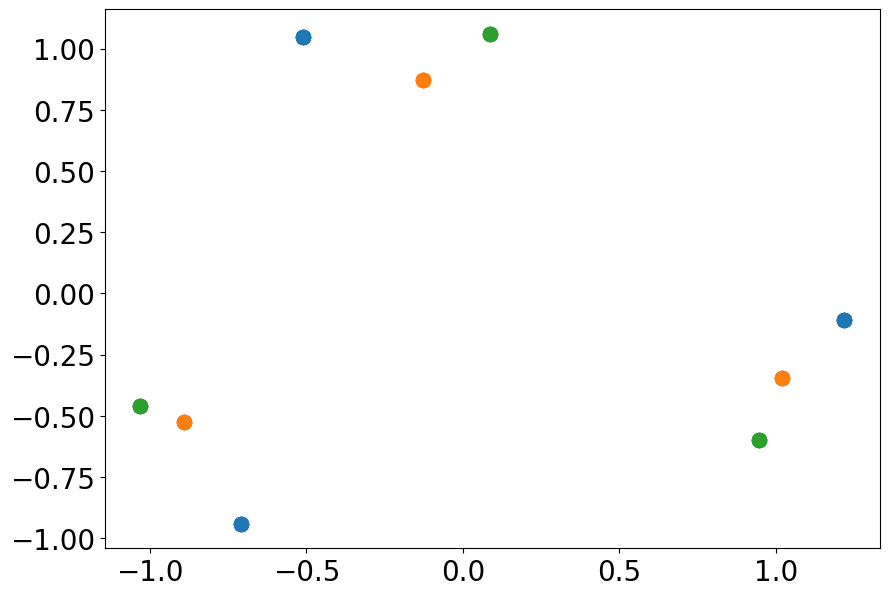

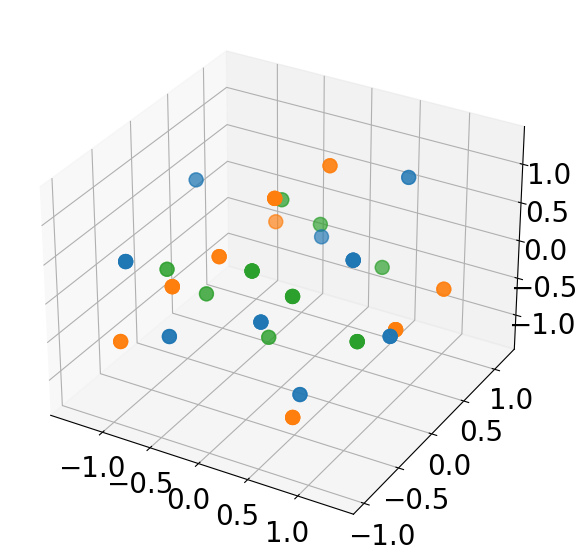

In [20]:
%matplotlib inline

plt.figure()
plt.scatter(low_stims['s'].reshape(2,27)[0], low_stims['s'].reshape(2,27)[1], s=100)
plt.scatter(low_stims['c'].reshape(2,27)[0], low_stims['c'].reshape(2,27)[1], s=100)
plt.scatter(low_stims['p'].reshape(2,27)[0], low_stims['p'].reshape(2,27)[1], s=100)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(low_stims['sc'].reshape(4,27)[0], low_stims['sc'].reshape(4,27)[1], low_stims['sc'].reshape(4,27)[2], s=100)
ax.scatter(low_stims['sp'].reshape(4,27)[0], low_stims['sp'].reshape(4,27)[1], low_stims['sp'].reshape(4,27)[2], s=100)
ax.scatter(low_stims['cp'].reshape(4,27)[0], low_stims['cp'].reshape(4,27)[1], low_stims['cp'].reshape(4,27)[2], s=100)
fig.show()


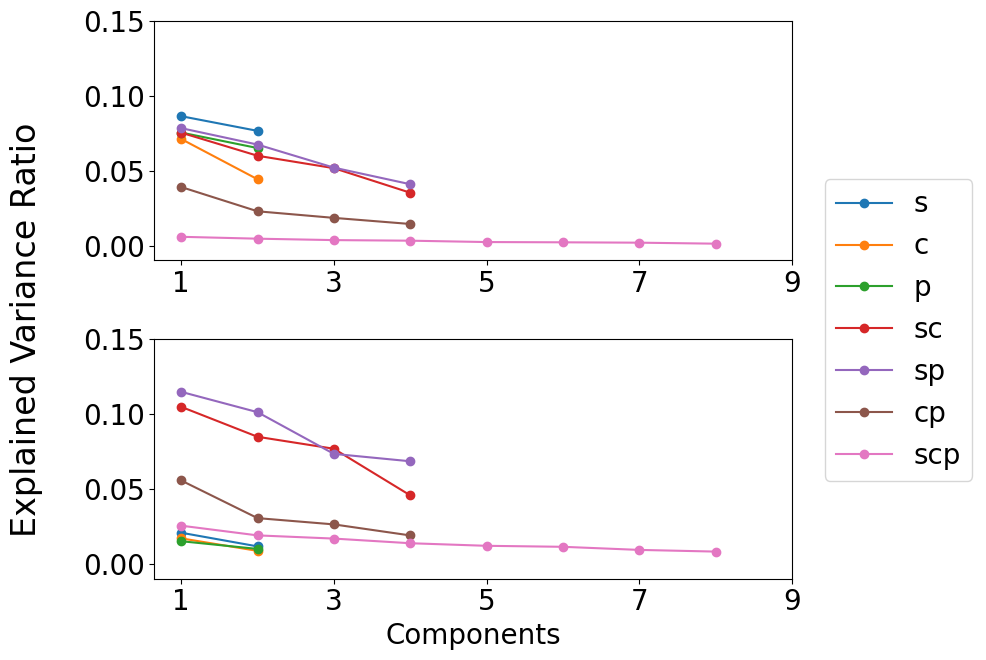

In [32]:
fig, axes = plt.subplots(2,1)

for k in low_stims.keys():
    axes[0].plot(dpca_in.explained_variance_ratio_[k][:10], '-o', label=k)
    axes[1].plot(dpca_out.explained_variance_ratio_[k][:10], '-o', label=k)

axes[1].set_xlabel('Components')
axes[0].set_xticks(np.arange(0,10,2))
axes[1].set_xticks(np.arange(0,10,2))
axes[0].set_xticklabels(np.arange(1,10,2))
axes[1].set_xticklabels(np.arange(1,10,2))
axes[0].set_ylim([-0.01, 0.15])
axes[1].set_ylim([-0.01, 0.15])
fig.supylabel('Explained Variance Ratio')
plt.tight_layout()
handles, labels = axes[0].get_legend_handles_labels()
box = axes[0].get_position()
axes[0].set_position([box.x0, box.y0, box.width * 0.8, box.height])
box = axes[1].get_position()
axes[1].set_position([box.x0, box.y0, box.width * 0.8, box.height])
fig.legend(handles, labels, loc='center right')

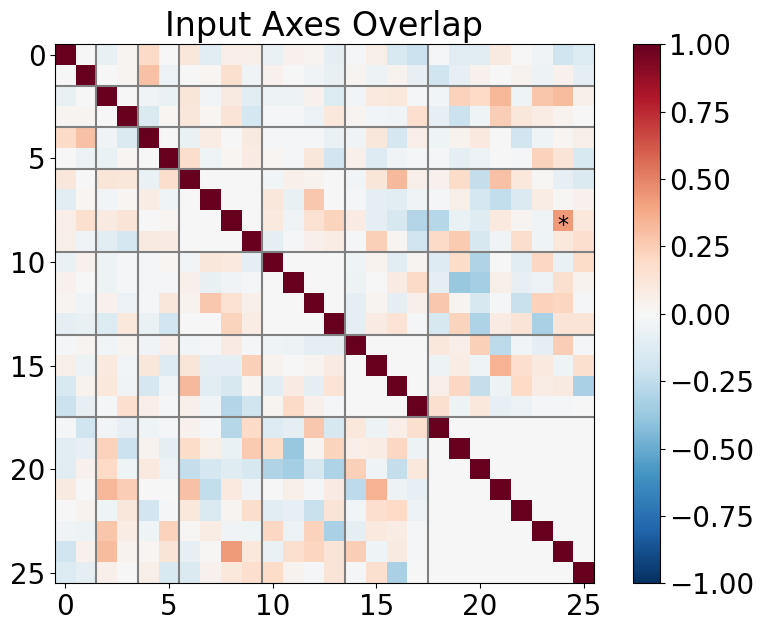

In [47]:
from scipy.stats import norm

all_dpca_axes = np.concatenate([dpca_in.P['s'], dpca_in.P['c'], dpca_in.P['p'], 
                                dpca_in.P['cp'], dpca_in.P['sp'], dpca_in.P['sc'], 
                                dpca_in.P['scp']], axis=1)
axes_overlap = all_dpca_axes.T@all_dpca_axes
sig_thresh = np.abs(norm.ppf(0.05/(26*25/2-3-7*3-28))/np.sqrt(80))

plt.imshow(axes_overlap, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Input Axes Overlap')
plt.xlabel('')

txs, tys = np.meshgrid(np.arange(6+12+8),np.arange(6+12+8))
txs = txs[np.abs(axes_overlap)>sig_thresh]
tys = tys[np.abs(axes_overlap)>sig_thresh]

block_boundaries = [1.5, 3.5, 5.5, 9.5, 13.5, 17.5]
for i in block_boundaries:
    plt.axvline(x=i,color='grey')
    plt.axhline(y=i,color='grey')
    
# plt.xticks([0.5,2.5,4.5,6.5,9,11.5,49], ['F1', 'F2', 'F3', 'C1', 'C2', 'C3', 'O'], size=16)
# plt.yticks([1,4,7,12,20,28,49], ['F1', 'F2', 'F3', 'C1', 'C2', 'C3', 'O'], size=16)

for (x,y) in zip(txs, tys):
    if x<=y:
        continue
    else:
        plt.text(x-0.25, y+0.55, '*', {'size': 16})

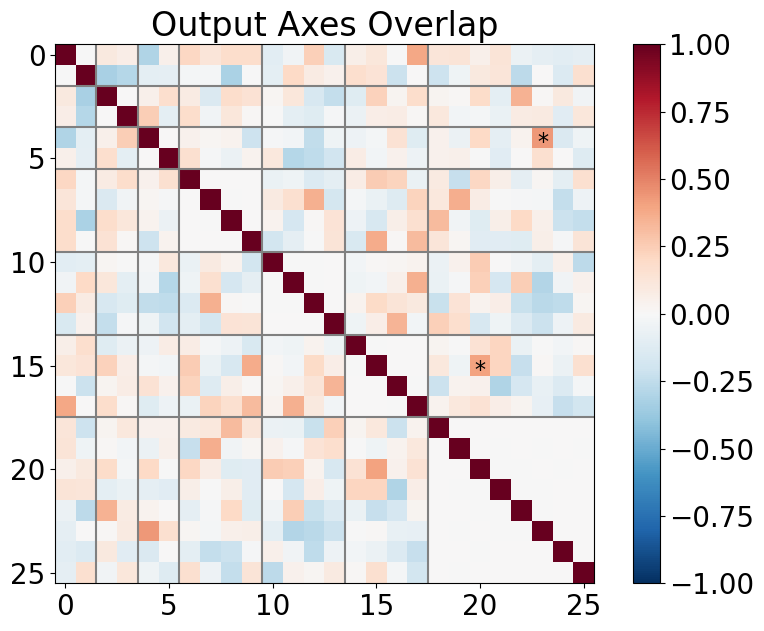

In [52]:
all_dpca_axes = np.concatenate([dpca_out.P['s'], dpca_out.P['c'], dpca_out.P['p'], 
                                dpca_out.P['cp'], dpca_out.P['sp'], dpca_out.P['sc'], 
                                dpca_out.P['scp']], axis=1)
axes_overlap = all_dpca_axes.T@all_dpca_axes
sig_thresh = np.abs(norm.ppf(0.05/(26*25/2-3-7*3-28))/np.sqrt(80))

plt.imshow(axes_overlap, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Output Axes Overlap')
plt.xlabel('')

txs, tys = np.meshgrid(np.arange(6+12+8),np.arange(6+12+8))
txs = txs[np.abs(axes_overlap)>sig_thresh]
tys = tys[np.abs(axes_overlap)>sig_thresh]

block_boundaries = [1.5, 3.5, 5.5, 9.5, 13.5, 17.5]
for i in block_boundaries:
    plt.axvline(x=i,color='grey')
    plt.axhline(y=i,color='grey')
    
# plt.xticks([0.5,2.5,4.5,6.5,9,11.5,49], ['F1', 'F2', 'F3', 'C1', 'C2', 'C3', 'O'], size=16)
# plt.yticks([1,4,7,12,20,28,49], ['F1', 'F2', 'F3', 'C1', 'C2', 'C3', 'O'], size=16)

for (x,y) in zip(txs, tys):
    if x<=y:
        continue
    else:
        plt.text(x-0.25, y+0.55, '*', {'size': 16})

The input and output weights are both low-rank, and their encoding subspaces have very little overlap.

# Activity of the Naive RNN

In [70]:
# shape [num pairs (216=27X8), samples per pair, time steps, batch size=1, num_hidden]

pair_to_ind = {(0,1): 0, (1,0): 0, (0,2): 1, (2,0): 1, (1,2): 2, (2,1): 2};

num_pairs, samples_per_pair, num_timesteps, _, num_hidden = all_initial_saved_states['hs'].shape

mat_for_dpca = np.empty((samples_per_pair, 3, 3, 3,  num_timesteps, num_hidden))

for pair_idx in range(task_mdprl.pairs.shape[0]):
    opt1_idx = task_mdprl.pairs[pair_idx,:][0]
    opt2_idx = task_mdprl.pairs[pair_idx,:][1]
    shp_idx = pair_to_ind[(task_mdprl.index_shp[opt1_idx], task_mdprl.index_shp[opt2_idx])]
    clr_idx = pair_to_ind[(task_mdprl.index_clr[opt1_idx], task_mdprl.index_clr[opt2_idx])]
    pttrn_idx = pair_to_ind[(task_mdprl.index_pttrn[opt1_idx], task_mdprl.index_pttrn[opt2_idx])]
    mat_for_dpca[:, shp_idx, clr_idx, pttrn_idx, :, :] = all_initial_saved_states['hs'][pair_idx,:,:,0,:].mean(0)
    
mat_for_dpca = mat_for_dpca.mean(0).transpose((4, 3, 0, 1, 2))

In [71]:
mat_for_dpca.shape

(240, 51, 3, 3, 3)

In [125]:
dpca_rec_area = []
low_stims = []

for i in range(NUM_AREAS):
    area_spec_units = list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                         list(range(3*E_SIZE+i*I_SIZE, 3*E_SIZE+(i+1)*I_SIZE))

    dpca_rec_area.append(dPCA.dPCA('tscp', n_components={'t':10, 'ts':7, 'tc':7, 'tp':7, 'tsc': 7, 'tsp':7, 'tcp':7, 'tscp':7},
                    join={'ts' : ['s','ts'], 'tc' : ['c','tc'], 'tp' : ['p','tp'], 
                          'tsp' : ['sp','tsp'], 'tsc' : ['sc','tsc'], 'tcp' : ['cp','tcp'],
                          'tscp' : ['scp','tscp'],}, regularizer=None))
    low_stims.append(dpca_rec_area[i].fit_transform(mat_for_dpca[area_spec_units]))


In [ ]:
fig, axes = plt.subplots(1,NUM_AREAS)

for i in range(NUM_AREAS):
    for k in low_stims.keys():
        if k!='t':
            axes[i].plot(dpca_rec_area[i].explained_variance_ratio_[k][:10], '-o', label=k)
            axes[i].set_xticks(np.arange(0,3))
            axes[i].set_xticklabels(np.arange(1,4))
            axes[i].set_ylim([-0.01, 0.15])
            print((i, k, dpca_rec_area[i].explained_variance_ratio_[k].sum()))
#             handles, labels = axes[i].get_legend_handles_labels()
#             box = axes[i].get_position()
#             axes[i].set_position([box.x0, box.y0, box.width * 0.8, box.height])


# axes.set_xlabel('Components')
fig.supylabel('Explained Variance Ratio')
plt.tight_layout()

fig.legend(handles, labels, loc='center right')

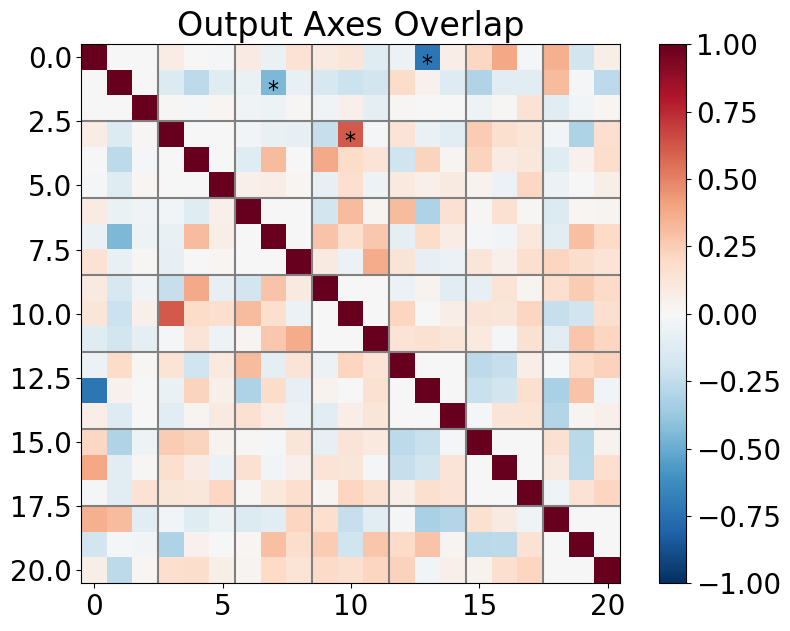

In [101]:
fig, axes = plt.subplots(1,NUM_AREAS)


for i in range(NUM_AREAS):

    all_dpca_axes = np.concatenate([dpca_rec_area[i].P['ts'], dpca_rec_area[i].P['tc'], dpca_rec_area[i].P['tp'], 
                                    dpca_rec_area[i].P['tcp'], dpca_rec_area[i].P['tsp'], dpca_rec_area[i].P['tsc'], 
                                    dpca_rec_area[i].P['tscp']], axis=1)
    axes_overlap = all_dpca_axes.T@all_dpca_axes
    sig_thresh = np.abs(norm.ppf(0.05/(26*25/2-3-7*3-28))/np.sqrt(80))

    axes[i].imshow(axes_overlap, cmap='RdBu_r', vmin=-1, vmax=1)
    axes[i].title('Output Axes Overlap')
    axes[i].xlabel('')

    txs, tys = np.meshgrid(np.arange(21),np.arange(21))
    txs = txs[np.abs(axes_overlap)>sig_thresh]
    tys = tys[np.abs(axes_overlap)>sig_thresh]

    block_boundaries = [2.5, 5.5, 8.5, 11.5, 14.5, 17.5]
    for i in block_boundaries:
        axes[i].axvline(x=i,color='grey')
        axes[i].axhline(y=i,color='grey')
        
    # plt.xticks([0.5,2.5,4.5,6.5,9,11.5,49], ['F1', 'F2', 'F3', 'C1', 'C2', 'C3', 'O'], size=16)
    # plt.yticks([1,4,7,12,20,28,49], ['F1', 'F2', 'F3', 'C1', 'C2', 'C3', 'O'], size=16)

    for (x,y) in zip(txs, tys):
        if x<=y:
            continue
        else:
            axes[i].text(x-0.25, y+0.55, '*', {'size': 16})